<a href="https://colab.research.google.com/github/Satvik0609/Lung_Cancer_Prediction/blob/main/lung_cancer_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os, math, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# PyTorch ViT for robust feature extraction (fixes TF safetensors error)
import torch
from transformers import ViTImageProcessor, ViTModel

In [5]:
# -----------------------
# Reproducibility
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
# -----------------------
# If running in Colab, optionally mount Drive
# -----------------------
try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
# -----------------------
# USER CONFIG (EDIT THESE)
# -----------------------
BASE_DIR = "/content/drive/MyDrive/cancers"
CLASS_DIRS = ["Benign", "Malignant", "Normal"]
NUM_CLASSES = len(CLASS_DIRS)

IMG_SIZE = (512, 512)
VIT_INPUT_SIZE = (224, 224)
FEATURE_DIM = 768

BATCH_SIZE = 8

# Training budgets (main AACNN adaptive gets more budget on purpose)
EPOCHS_CNN = 15
EPOCHS_VIT = 15
EPOCHS_CNNVIT = 15

EPOCHS_ADAPT_STAGE_A = 10
EPOCHS_ADAPT_STAGE_B = 20

EPOCHS_NOADAPT_STAGE_A = 8
EPOCHS_NOADAPT_STAGE_B = 12

UNFREEZE_LAST_N = 60

# MixUp: apply only to main adaptive AACNN if desired
ADAPT_MIXUP_ALPHA = 0.20
NOADAPT_MIXUP_ALPHA = 0.00

VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"

TRAIN_FEATURES_PATH = os.path.join(BASE_DIR, "train_vit_features.npy")
VAL_FEATURES_PATH   = os.path.join(BASE_DIR, "val_vit_features.npy")

print("BASE_DIR:", BASE_DIR)
print("Classes:", CLASS_DIRS)

BASE_DIR: /content/drive/MyDrive/cancers
Classes: ['Benign', 'Malignant', 'Normal']


In [8]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/cancers/archive (2).zip"
extract_path = "/content/cancers"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")


Extraction completed!


In [9]:
print(os.listdir("/content/cancers"))


['The IQ-OTHNCCD lung cancer dataset']


In [10]:
print(os.listdir("/content/cancers/" + os.listdir("/content/cancers")[0]))


['Normal cases', 'Malignant cases', 'IQ-OTH_NCCD lung cancer dataset.txt', 'Bengin cases']


In [11]:
# ============================================================
# REQUIRED BEFORE ViT FEATURE EXTRACTION
# Creates: X_train, X_val, y_train_int, y_val_int, y_train_oh, y_val_oh
# ============================================================
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

SEED = 42

BASE_DIR = os.path.join("/content/cancers", os.listdir("/content/cancers")[0])

# Only keep actual folders (ignore txt file)
CLASS_DIRS = sorted([
    d for d in os.listdir(BASE_DIR)
    if os.path.isdir(os.path.join(BASE_DIR, d))
])
NUM_CLASSES = len(CLASS_DIRS)
TRAIN_SIZE = 0.70

def load_paths_and_labels(base_dir, class_dirs):
    paths, y_int = [], []
    for ci, cname in enumerate(class_dirs):
        cdir = os.path.join(base_dir, cname)
        if not os.path.isdir(cdir):
            raise FileNotFoundError(f"Missing class folder: {cdir}")
        for root, _, files in os.walk(cdir):
            for f in files:
                if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff",".webp")):
                    paths.append(os.path.join(root, f))
                    y_int.append(ci)
    return np.array(paths), np.array(y_int, dtype=np.int32)

all_paths, all_y_int = load_paths_and_labels(BASE_DIR, CLASS_DIRS)

X_train, X_val, y_train_int, y_val_int = train_test_split(
    all_paths, all_y_int,
    train_size=TRAIN_SIZE,
    stratify=all_y_int,
    random_state=SEED
)

y_train_oh = tf.keras.utils.to_categorical(y_train_int, NUM_CLASSES)
y_val_oh   = tf.keras.utils.to_categorical(y_val_int,   NUM_CLASSES)

print("Train:", X_train.shape, y_train_oh.shape)
print("Val:",   X_val.shape,   y_val_oh.shape)

Train: (767,) (767, 3)
Val: (330,) (330, 3)


In [12]:
def extract_vit_features(image_paths, save_path, batch_size=BATCH_SIZE):
    if os.path.exists(save_path):
        feats = np.load(save_path, allow_pickle=True)
        if feats.shape[0] == len(image_paths):
            print(f"Loaded cached ViT features: {save_path} | {feats.shape}")
            return feats
        print("[WARN] Cache mismatch. Recomputing...")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("ViT extraction device:", device)

    processor = ViTImageProcessor.from_pretrained(VIT_MODEL_NAME)
    vit = ViTModel.from_pretrained(VIT_MODEL_NAME).to(device)
    vit.eval()

    feats_list = []
    for start in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[start:start + batch_size]
        batch_imgs = []
        for p in batch_paths:
            img = tf.keras.preprocessing.image.load_img(p, target_size=VIT_INPUT_SIZE)
            arr = tf.keras.preprocessing.image.img_to_array(img)  # 0..255
            batch_imgs.append(arr)

        inputs = processor(images=np.array(batch_imgs), return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            out = vit(**inputs)
            cls = out.last_hidden_state[:, 0, :]  # [B,768]
            feats_list.append(cls.cpu().numpy().astype(np.float32))

    feats = np.concatenate(feats_list, axis=0).astype(np.float32)
    np.save(save_path, feats)
    print(f"Saved ViT features: {save_path} | {feats.shape}")
    return feats

train_features = extract_vit_features(X_train, TRAIN_FEATURES_PATH)
val_features   = extract_vit_features(X_val,   VAL_FEATURES_PATH)

print("train_features:", train_features.shape)
print("val_features:", val_features.shape)

Loaded cached ViT features: /content/drive/MyDrive/cancers/train_vit_features.npy | (767, 768)
Loaded cached ViT features: /content/drive/MyDrive/cancers/val_vit_features.npy | (330, 768)
train_features: (767, 768)
val_features: (330, 768)


In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.15,
    zoom_range=0.20,
    horizontal_flip=True,
    brightness_range=[0.85, 1.15],
    channel_shift_range=15
)
val_datagen = ImageDataGenerator()

def load_img_01(path, augment=False):
    img = tf.keras.preprocessing.image.load_img(path, target_size=IMG_SIZE)
    arr = tf.keras.preprocessing.image.img_to_array(img)
    if augment:
        arr = train_datagen.random_transform(arr)
    return (arr / 255.0).astype(np.float32)


In [14]:
class CNNSequence(tf.keras.utils.Sequence):
    def __init__(self, paths, y_oh, bs, shuffle=True, augment=False, seed=SEED):
        self.paths = list(paths)
        self.y = np.asarray(y_oh, dtype=np.float32)
        self.bs = bs
        self.shuffle = shuffle
        self.augment = augment
        self.rng = np.random.default_rng(seed)
        self.idxs = np.arange(len(self.paths))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.paths) / self.bs)

    def on_epoch_end(self):
        if self.shuffle:
            self.rng.shuffle(self.idxs)

    def __getitem__(self, i):
        bi = self.idxs[i*self.bs:(i+1)*self.bs]
        bx = np.stack([load_img_01(self.paths[k], augment=self.augment) for k in bi], axis=0)
        by = self.y[bi]
        # IMPORTANT: bx is a numpy array (NOT a list)
        return bx, by


class ViTSequence(tf.keras.utils.Sequence):
    def __init__(self, vit_feats, y_oh, bs, shuffle=True, seed=SEED):
        self.vit = np.asarray(vit_feats, dtype=np.float32)
        self.y = np.asarray(y_oh, dtype=np.float32)
        self.bs = bs
        self.shuffle = shuffle
        self.rng = np.random.default_rng(seed)
        self.idxs = np.arange(len(self.vit))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.vit) / self.bs)

    def on_epoch_end(self):
        if self.shuffle:
            self.rng.shuffle(self.idxs)

    def __getitem__(self, i):
        bi = self.idxs[i*self.bs:(i+1)*self.bs]
        # IMPORTANT: returns (array, array), no lists
        return self.vit[bi], self.y[bi]


class FusionSequence(tf.keras.utils.Sequence):
    def __init__(self, paths, y_oh, vit_feats, bs,
                 shuffle=True, augment=False, mixup_alpha=0.0, seed=SEED):
        self.paths = list(paths)
        self.y = np.asarray(y_oh, dtype=np.float32)
        self.vit = np.asarray(vit_feats, dtype=np.float32)
        self.bs = bs
        self.shuffle = shuffle
        self.augment = augment
        self.mixup_alpha = float(mixup_alpha)
        self.rng = np.random.default_rng(seed)
        self.idxs = np.arange(len(self.paths))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.paths) / self.bs)

    def on_epoch_end(self):
        if self.shuffle:
            self.rng.shuffle(self.idxs)

    def __getitem__(self, i):
        bi = self.idxs[i*self.bs:(i+1)*self.bs]
        bx_paths = [self.paths[k] for k in bi]

        bx_img = np.stack([load_img_01(p, augment=self.augment) for p in bx_paths], axis=0)
        bx_vit = self.vit[bi].copy()
        by = self.y[bi].copy()

        if self.mixup_alpha and self.mixup_alpha > 0:
            partner = self.rng.choice(bi, size=len(bi), replace=True)
            lam = self.rng.beta(self.mixup_alpha, self.mixup_alpha, size=(len(bi), 1)).astype(np.float32)

            lam_img = lam.reshape(-1, 1, 1, 1)
            bx_img2 = np.stack([load_img_01(self.paths[k], augment=self.augment) for k in partner], axis=0)
            bx_img = lam_img * bx_img + (1 - lam_img) * bx_img2

            bx_vit2 = self.vit[partner]
            bx_vit = lam * bx_vit + (1 - lam) * bx_vit2

            by2 = self.y[partner]
            by = lam * by + (1 - lam) * by2

        # IMPORTANT: tuple of inputs, not list
        return (bx_img, bx_vit), by


# Recreate sequences AFTER redefining classes
cnn_train = CNNSequence(X_train, y_train_oh, BATCH_SIZE, shuffle=True, augment=True)
cnn_val   = CNNSequence(X_val,   y_val_oh,   BATCH_SIZE, shuffle=False, augment=False)

vit_train = ViTSequence(train_features, y_train_oh, BATCH_SIZE, shuffle=True)
vit_val   = ViTSequence(val_features,   y_val_oh,   BATCH_SIZE, shuffle=False)

fusion_train = FusionSequence(X_train, y_train_oh, train_features, BATCH_SIZE, shuffle=True, augment=True, mixup_alpha=0.0)
fusion_val   = FusionSequence(X_val,   y_val_oh,   val_features,   BATCH_SIZE, shuffle=False, augment=False, mixup_alpha=0.0)

adapt_train  = FusionSequence(X_train, y_train_oh, train_features, BATCH_SIZE, shuffle=True, augment=True, mixup_alpha=ADAPT_MIXUP_ALPHA)
noadapt_train= FusionSequence(X_train, y_train_oh, train_features, BATCH_SIZE, shuffle=True, augment=True, mixup_alpha=NOADAPT_MIXUP_ALPHA)


In [15]:
def hybrid_loss(alpha=0.25, gamma=2.0):
    cce = tf.keras.losses.CategoricalCrossentropy()
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce = cce(y_true, y_pred)

        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_w = alpha * tf.pow(1 - p_t, gamma)
        focal = tf.reduce_mean(focal_w * (-y_true) * tf.math.log(y_pred))
        return 0.7 * focal + 0.3 * ce
    return loss_fn

def compile_model(model, lr):
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=5e-6)
    except Exception:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=hybrid_loss(), metrics=["accuracy"])
    return model

def staged_train_and_plot(model, train_seq, val_seq, class_weights,
                          epochs_a, epochs_b, unfreeze_last_n,
                          title, ckpt_prefix,
                          lr_a=2e-4, lr_b=5e-5):

    # Guard: prevent passing dicts by mistake
    if isinstance(model, dict):
        raise TypeError("staged_train_and_plot received a dict, not a Keras model. "
                        "You likely overwrote the model variable with a history dict.")

    def callbacks(tag):
        return [
            tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
            tf.keras.callbacks.ModelCheckpoint(f"{ckpt_prefix}_{tag}.keras",
                                               monitor="val_accuracy", save_best_only=True)
        ]

    backbone = getattr(model, "_cnn_backbone", None)

    # -------------------------
    # Stage A: backbone frozen
    # -------------------------
    if backbone is not None:
        backbone.trainable = False

    compile_model(model, lr=lr_a)
    print(f"\n[{ckpt_prefix}] Stage A...")
    hA = model.fit(
        train_seq,
        validation_data=val_seq,
        epochs=epochs_a,
        class_weight=class_weights,
        callbacks=callbacks("A"),
        verbose=1
    )

    # ------------------------------------
    # Stage B: unfreeze last N of backbone
    # ------------------------------------
    if backbone is not None:
        backbone.trainable = True
        # freeze all except last N layers
        for layer in backbone.layers[:-unfreeze_last_n]:
            layer.trainable = False
        for layer in backbone.layers[-unfreeze_last_n:]:
            layer.trainable = True

    compile_model(model, lr=lr_b)
    print(f"\n[{ckpt_prefix}] Stage B...")
    hB = model.fit(
        train_seq,
        validation_data=val_seq,
        epochs=epochs_b,
        class_weight=class_weights,
        callbacks=callbacks("B"),
        verbose=1
    )

    merged = _merge_histories([hA, hB])
    plot_acc_loss(merged, title)

    y_true_oh, y_prob = collect_probs_and_labels(model, val_seq, mode="fusion")
    plot_multiclass_roc(y_true_oh, y_prob, CLASS_DIRS, title)

    # IMPORTANT: return model AND history
    return model, merged

In [16]:
# --- CNN baseline ---
def build_cnn_baseline():
    inp = layers.Input(shape=(*IMG_SIZE,3))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return tf.keras.Model(inp, out, name="CNN_Baseline")


# --- ViT head (feature-only) ---
def build_vit_head():
    inp = layers.Input(shape=(FEATURE_DIM,))
    x = layers.Dense(256, activation="relu")(inp)
    x = layers.Dropout(0.35)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.35)(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return tf.keras.Model(inp, out, name="ViT_Head")


# --- CNN-ViT baseline (concat) ---
def build_cnn_vit():
    img_in = layers.Input(shape=(*IMG_SIZE,3), name="image_input")
    vit_in = layers.Input(shape=(FEATURE_DIM,), name="vit_features_input")

    x = layers.Conv2D(16, 3, padding="same", activation="relu")(img_in)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    cnn_feat = layers.GlobalAveragePooling2D(name="cnn_gap")(x)

    fused = layers.Concatenate()([cnn_feat, vit_in])
    h = layers.Dense(256, activation="relu")(fused)
    h = layers.Dropout(0.5)(h)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(h)

    return tf.keras.Model([img_in, vit_in], out, name="CNN_ViT")


# --- AACNN helpers ---
class AdaptiveGate(layers.Layer):
    def __init__(self, d_hidden=128, dropout=0.25, l2=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.concat = layers.Concatenate()
        self.d1 = layers.Dense(d_hidden, activation="relu", kernel_regularizer=regularizers.l2(l2))
        self.drop = layers.Dropout(dropout)
        self.logit = layers.Dense(1, kernel_initializer="zeros", bias_initializer="zeros")
        self.sigmoid = layers.Activation("sigmoid")
    def call(self, a, b, training=False):
        h = self.concat([a,b])
        h = self.d1(h)
        h = self.drop(h, training=training)
        alpha = self.sigmoid(self.logit(h))
        return alpha*a + (1-alpha)*b

def _resnet_backbone(img_in):
    base = tf.keras.applications.ResNet50(
        include_top=False, weights="imagenet",
        input_shape=(*IMG_SIZE,3), pooling="avg", name="cnn_backbone"
    )
    base.trainable = False
    x_img = layers.Lambda(lambda z: tf.keras.applications.resnet.preprocess_input(z*255.0),
                          name="resnet_preprocess")(img_in)
    feat = base(x_img)
    return base, feat

def build_aacnn_adaptive(d_model=256, l2=1e-4):
    img_in = layers.Input(shape=(*IMG_SIZE,3), name="image_input")
    vit_in = layers.Input(shape=(FEATURE_DIM,), name="vit_features_input")
    base, cnn_feat = _resnet_backbone(img_in)

    cnn_feat = layers.Dense(512, activation="relu")(cnn_feat)
    cnn_feat = layers.Dropout(0.25)(cnn_feat)
    cnn_tok = layers.Dense(d_model, activation="relu", kernel_regularizer=regularizers.l2(l2), name="cnn_token")(cnn_feat)

    vit_feat = layers.LayerNormalization()(vit_in)
    vit_feat = layers.Dense(512, activation="gelu")(vit_feat)
    vit_feat = layers.Dropout(0.25)(vit_feat)
    vit_tok = layers.Dense(d_model, activation="gelu", kernel_regularizer=regularizers.l2(l2), name="vit_token")(vit_feat)

    gated = AdaptiveGate(name="adaptive_gate")(cnn_tok, vit_tok)

    tokens = layers.Lambda(lambda t: tf.stack(t, axis=1), name="stack_tokens")([cnn_tok, vit_tok])  # [B,2,D]
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=d_model//4, dropout=0.10, name="cross_attn")
    attn_out = attn(tokens, tokens)
    attn_out = layers.Add()([tokens, attn_out])
    attn_out = layers.LayerNormalization()(attn_out)
    attn_flat = layers.Flatten(name="attn_flat")(attn_out)

    fused = layers.Concatenate(name="fusion_concat")([gated, cnn_tok, vit_tok, attn_flat])

    h = layers.Dense(1024, activation="gelu", kernel_regularizer=regularizers.l2(l2))(fused)
    h = layers.Dropout(0.40)(h)
    h = layers.Dense(512, activation="gelu", kernel_regularizer=regularizers.l2(l2))(h)
    h = layers.Dropout(0.35)(h)
    h = layers.Dense(256, activation="gelu")(h)
    h = layers.Dropout(0.30)(h)
    out = layers.Dense(NUM_CLASSES, activation="softmax", name="classifier")(h)

    model = tf.keras.Model([img_in, vit_in], out, name="AACNN_ViT_ADAPTIVE")
    model._cnn_backbone = base
    return model


cnn_model = build_cnn_baseline()
vit_model = build_vit_head()
cnnvit_model = build_cnn_vit()
aacnn_adapt = build_aacnn_adaptive()

cnn_model.summary()
vit_model.summary()
cnnvit_model.summary()
aacnn_adapt.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "CNN_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,043 (496.26 KB)

 Trainable params: 127,043 (496.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "ViT_Head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,147 (899.01 KB)

 Trainable params: 230,147 (899.01 KB)

 Non-trainable params: 0 (0.00 B)

Model: "CNN_ViT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 512, 512,  │        448 │ image_input[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 256, 256,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_gap             │ (None, 64)        │          0 │ conv2d_5[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vit_features_input  │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 832)       │          0 │ cnn_gap[0][0],    │
│ (Concatenate)       │                   │            │ vit_features_inp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    213,248 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3)         │        771 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 237,603 (928.14 KB)

 Trainable params: 237,603 (928.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "AACNN_ViT_ADAPTIVE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_preprocess   │ (None, 512, 512,  │          0 │ image_input[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vit_features_input  │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_backbone        │ (None, 2048)      │ 23,587,712 │ resnet_preproces… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 768)       │      1,536 │ vit_features_inp… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │  1,049,088 │ cnn_backbone[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │    393,728 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_token (Dense)   │ (None, 256)       │    131,328 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vit_token (Dense)   │ (None, 256)       │    131,328 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_tokens        │ (None, 2, 256)    │          0 │ cnn_token[0][0],  │
│ (Lambda)            │                   │            │ vit_token[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attn          │ (None, 2, 256)    │    263,168 │ stack_tokens[0][… │
│ (MultiHeadAttentio… │                   │            │ stack_tokens[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2, 256)    │          0 │ stack_tokens[0][… │
│                     │                   │            │ cross_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 256)    │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adaptive_gate       │ (None, 256)       │     65,793 │ cnn_token[0][0],  │
│ (AdaptiveGate)      │                   │            │ vit_token[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_flat (Flatten) │ (None, 512)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_concat       │ (None, 1280)      │          0 │ adaptive_gate[0]… │
│ (Concatenate)       │                   │            │ cnn_token[0][0],  │
│                     │                   │            │ vit_token[0][0],  │
│                     │                   │            │ attn_flat[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 27,592,836 (105.26 MB)

 Trainable params: 4,005,124 (15.28 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def _merge_histories(hist_list):
    """
    Merge multiple tf.keras History objects into a single dict,
    used for staged training (Stage A + Stage B).
    """
    merged = {}
    for h in hist_list:
        if h is None:
            continue
        for k, v in h.history.items():
            merged.setdefault(k, [])
            merged[k].extend(list(v))
    return merged

def plot_acc_loss(history_dict, title):
    """
    history_dict: dict from history.history (or merged dict)
    """
    # Accuracy plot
    plt.figure(figsize=(8, 4))
    if "accuracy" in history_dict:
        plt.plot(history_dict["accuracy"], label="Train Accuracy")
    if "val_accuracy" in history_dict:
        plt.plot(history_dict["val_accuracy"], label="Val Accuracy")
    plt.title(f"{title} — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Loss plot
    plt.figure(figsize=(8, 4))
    if "loss" in history_dict:
        plt.plot(history_dict["loss"], label="Train Loss")
    if "val_loss" in history_dict:
        plt.plot(history_dict["val_loss"], label="Val Loss")
    plt.title(f"{title} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

def collect_probs_and_labels(model, val_seq, mode="cnn"):
    """
    Returns:
      y_true_oh: [N, C]
      y_prob:    [N, C]
    mode in {"cnn","vit","fusion"}
    """
    y_true = []
    y_prob = []

    for i in range(len(val_seq)):
        bx, by = val_seq[i]

        if mode == "fusion":
            # bx is (bx_img, bx_vit) after your tuple fix
            preds = model.predict(bx, verbose=0)
        else:
            preds = model.predict(bx, verbose=0)

        y_true.append(by)
        y_prob.append(preds)

    y_true_oh = np.concatenate(y_true, axis=0)
    y_prob = np.concatenate(y_prob, axis=0)
    return y_true_oh, y_prob

def plot_multiclass_roc(y_true_oh, y_prob, class_names, title):
    """
    One-vs-rest ROC for each class + micro-average.
    """
    n_classes = y_true_oh.shape[1]

    # Per-class ROC
    fpr = {}
    tpr = {}
    roc_auc = {}

    for c in range(n_classes):
        fpr[c], tpr[c], _ = roc_curve(y_true_oh[:, c], y_prob[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    # Micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_oh.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    for c in range(n_classes):
        plt.plot(fpr[c], tpr[c], label=f"{class_names[c]} (AUC={roc_auc[c]:.3f})")

    plt.plot(fpr["micro"], tpr["micro"], linestyle="--", label=f"Micro-average (AUC={roc_auc['micro']:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")

    plt.title(f"{title} — ROC (OvR)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [18]:
def train_and_plot_cnn(model, train_seq, val_seq, epochs, class_weights, title, lr=1e-4):
    compile_model(model, lr=lr)
    h = model.fit(
        train_seq,
        validation_data=val_seq,
        epochs=epochs,
        class_weight=class_weights,
        verbose=1
    )
    hist = h.history
    plot_acc_loss(hist, title)

    y_true_oh, y_prob = collect_probs_and_labels(model, val_seq, mode="cnn")
    plot_multiclass_roc(y_true_oh, y_prob, CLASS_DIRS, title)
    return hist

def train_and_plot_vit(model, train_seq, val_seq, epochs, class_weights, title, lr=1e-4):
    compile_model(model, lr=lr)
    h = model.fit(
        train_seq,
        validation_data=val_seq,
        epochs=epochs,
        class_weight=class_weights,
        verbose=1
    )
    hist = h.history
    plot_acc_loss(hist, title)

    y_true_oh, y_prob = collect_probs_and_labels(model, val_seq, mode="vit")
    plot_multiclass_roc(y_true_oh, y_prob, CLASS_DIRS, title)
    return hist

def train_and_plot_fusion(model, train_seq, val_seq, epochs, class_weights, title, lr=1e-4):
    compile_model(model, lr=lr)
    h = model.fit(
        train_seq,
        validation_data=val_seq,
        epochs=epochs,
        class_weight=class_weights,
        verbose=1
    )
    hist = h.history
    plot_acc_loss(hist, title)

    y_true_oh, y_prob = collect_probs_and_labels(model, val_seq, mode="fusion")
    plot_multiclass_roc(y_true_oh, y_prob, CLASS_DIRS, title)
    return hist


In [20]:
# -----------------------
# Class weights for imbalanced datasets
# -----------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# CNN
compile_model(cnn_model, lr=1e-4)
cnn_model.fit(cnn_train, validation_data=cnn_val, epochs=EPOCHS_CNN, class_weight=class_weights, verbose=1)

# ViT head
compile_model(vit_model, lr=1e-4)
vit_model.fit(vit_train, validation_data=vit_val, epochs=EPOCHS_VIT, class_weight=class_weights, verbose=1)

# CNN-ViT
compile_model(cnnvit_model, lr=1e-4)
cnnvit_model.fit(fusion_train, validation_data=fusion_val, epochs=EPOCHS_CNNVIT, class_weight=class_weights, verbose=1)



Class weights: {0: np.float64(3.0436507936507935), 1: np.float64(0.6522108843537415), 2: np.float64(0.8785796105383734)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 686ms/step - accuracy: 0.4546 - loss: 0.3302 - val_accuracy: 0.5121 - val_loss: 0.3120
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 64s 672ms/step - accuracy: 0.5120 - loss: 0.3257 - val_accuracy: 0.5697 - val_loss: 0.3049
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 62s 649ms/step - accuracy: 0.4545 - loss: 0.3403 - val_accuracy: 0.5848 - val_loss: 0.2985
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 635ms/step - accuracy: 0.5365 - loss: 0.3036 - val_accuracy: 0.5848 - val_loss: 0.2890
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 614ms/step - accuracy: 0.5874 - loss: 0.3049 - val_accuracy: 0.5848 - val_loss: 0.2753
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 64s 653ms/step - accuracy: 0.5941 - loss: 0.3155 - val_accuracy: 0.6848 - val_loss: 0.2725
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 62s 650ms/step - accuracy: 0.6506 - loss: 0.2833 - val_accuracy: 0.8000 - val_loss: 0.2483
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 614ms/step - accuracy: 0.6366 - loss: 0.2668 - val_accu


[AACNN_ADAPT] Stage A...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.6522 - loss: 0.5566 - val_accuracy: 0.8545 - val_loss: 0.3615 - learning_rate: 2.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8248 - loss: 0.4366 - val_accuracy: 0.8788 - val_loss: 0.3416 - learning_rate: 2.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8369 - loss: 0.3974 - val_accuracy: 0.8636 - val_loss: 0.3449 - learning_rate: 2.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.7791 - loss: 0.4351 - val_accuracy: 0.8636 - val_loss: 0.3220 - learning_rate: 2.0000e-04
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8511 - loss: 0.3774 - val_accuracy: 0.6879 - val_loss: 0.3737 - learning_rate: 2.0000e-04
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8222 - loss: 0.3931 - val_accuracy: 0.7848 - val_loss: 0.3352 - learning_rate: 2.0000e-04
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 112s 1

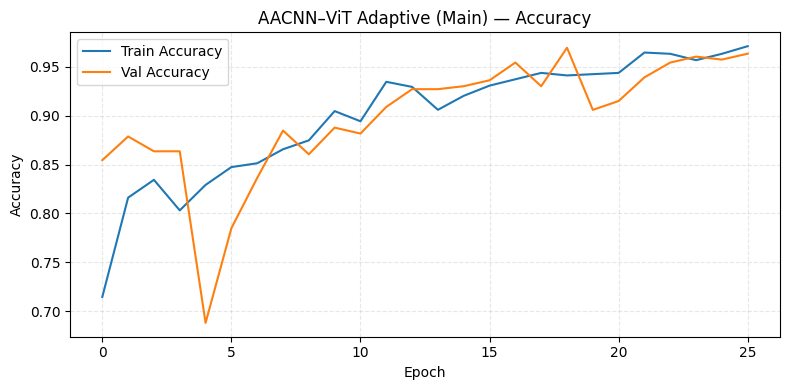

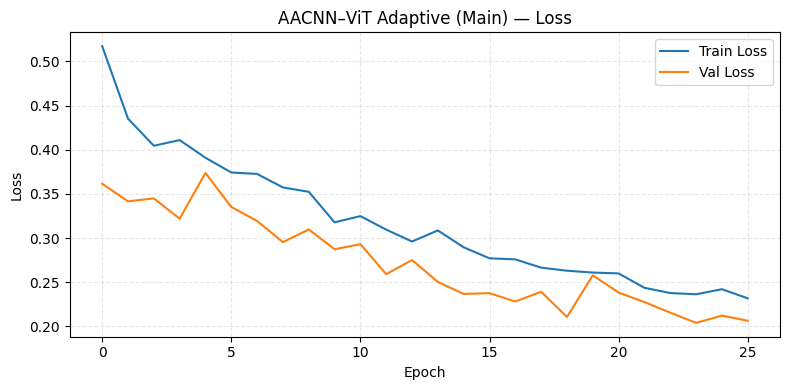

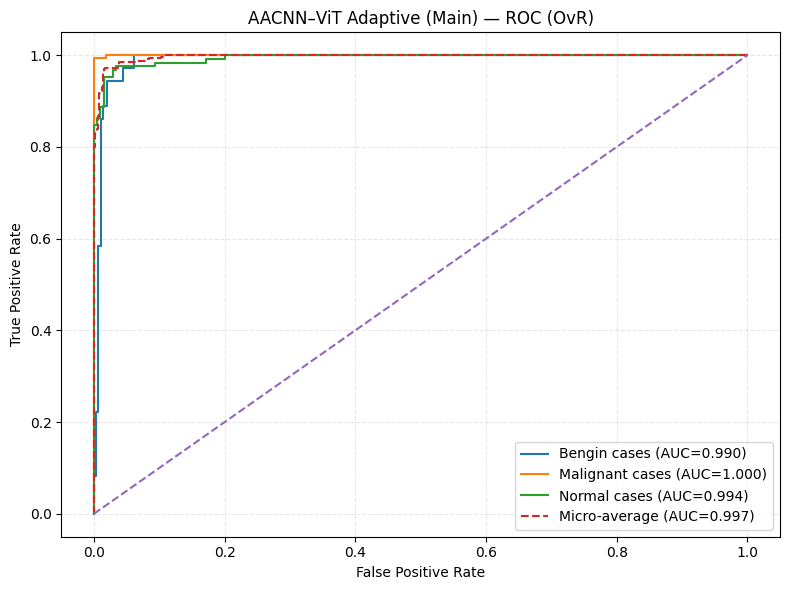

In [21]:
# MAIN (adaptive) – staged fine-tuning
aacnn_adapt, hist_aacnn_adapt = staged_train_and_plot(
    aacnn_adapt,
    train_seq=adapt_train,
    val_seq=fusion_val,
    class_weights=class_weights,
    epochs_a=EPOCHS_ADAPT_STAGE_A,
    epochs_b=EPOCHS_ADAPT_STAGE_B,
    unfreeze_last_n=UNFREEZE_LAST_N,
    title='AACNN–ViT Adaptive (Main)',
    ckpt_prefix="AACNN_ADAPT"
)

In [22]:
def eval_cnn(model, seq, class_names):
    y_true, y_pred = [], []
    for i in range(len(seq)):
        bx, by = seq[i]
        pr = model.predict(bx, verbose=0)
        y_true.append(np.argmax(by, axis=1))
        y_pred.append(np.argmax(pr, axis=1))
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

def eval_vit(model, seq, class_names):
    y_true, y_pred = [], []
    for i in range(len(seq)):
        bx, by = seq[i]
        pr = model.predict(bx, verbose=0)
        y_true.append(np.argmax(by, axis=1))
        y_pred.append(np.argmax(pr, axis=1))
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

def eval_fusion(model, seq, class_names):
    y_true, y_pred = [], []
    for i in range(len(seq)):
        (bx_img, bx_vit), by = seq[i]
        pr = model.predict([bx_img, bx_vit], verbose=0)
        y_true.append(np.argmax(by, axis=1))
        y_pred.append(np.argmax(pr, axis=1))
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

print("\n=== CNN ===")
eval_cnn(cnn_model, cnn_val, CLASS_DIRS)

print("\n=== ViT Head ===")
eval_vit(vit_model, vit_val, CLASS_DIRS)

print("\n=== CNN-ViT ===")
eval_fusion(cnnvit_model, fusion_val, CLASS_DIRS)


=== CNN ===
[[  0   0  36]
 [  0  65 104]
 [  0   0 125]]
                 precision    recall  f1-score   support

   Bengin cases     0.0000    0.0000    0.0000        36
Malignant cases     1.0000    0.3846    0.5556       169
   Normal cases     0.4717    1.0000    0.6410       125

       accuracy                         0.5758       330
      macro avg     0.4906    0.4615    0.3989       330
   weighted avg     0.6908    0.5758    0.5273       330


=== ViT Head ===
[[  8   0  28]
 [  0 166   3]
 [  1   1 123]]
                 precision    recall  f1-score   support

   Bengin cases     0.8889    0.2222    0.3556        36
Malignant cases     0.9940    0.9822    0.9881       169
   Normal cases     0.7987    0.9840    0.8817       125

       accuracy                         0.9000       330
      macro avg     0.8939    0.7295    0.7418       330
   weighted avg     0.9086    0.9000    0.8788       330


=== CNN-ViT ===
[[ 13   0  23]
 [  0 166   3]
 [  1   1 123]]
          

In [23]:
print("\n=== AACNN Adaptive ===")
eval_fusion(aacnn_adapt, fusion_val, CLASS_DIRS)

# print("\n=== AACNN No-Adaptive ===")
# eval_fusion(aacnn_noadapt, fusion_val, CLASS_DIRS)


=== AACNN Adaptive ===
[[ 32   0   4]
 [  0 167   2]
 [  4   0 121]]
                 precision    recall  f1-score   support

   Bengin cases     0.8889    0.8889    0.8889        36
Malignant cases     1.0000    0.9882    0.9940       169
   Normal cases     0.9528    0.9680    0.9603       125

       accuracy                         0.9697       330
      macro avg     0.9472    0.9484    0.9478       330
   weighted avg     0.9700    0.9697    0.9698       330



Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 806ms/step - accuracy: 0.7334 - loss: 0.2426 - val_accuracy: 0.6697 - val_loss: 0.2315
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 597ms/step - accuracy: 0.7415 - loss: 0.2428 - val_accuracy: 0.6000 - val_loss: 0.2782
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 65s 676ms/step - accuracy: 0.7592 - loss: 0.2078 - val_accuracy: 0.6879 - val_loss: 0.2253
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 594ms/step - accuracy: 0.7588 - loss: 0.2331 - val_accuracy: 0.6939 - val_loss: 0.2171
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 602ms/step - accuracy: 0.7618 - loss: 0.1986 - val_accuracy: 0.6970 - val_loss: 0.2171
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 60s 620ms/step - accuracy: 0.7727 - loss: 0.2217 - val_accuracy: 0.6061 - val_loss: 0.2910
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 601ms/step - accuracy: 0.7738 - loss: 0.2142 - val_accuracy: 0.6939 - val_loss: 0.2234
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 581ms/step - accuracy: 0.7544 - loss: 0.2026 - val_accu

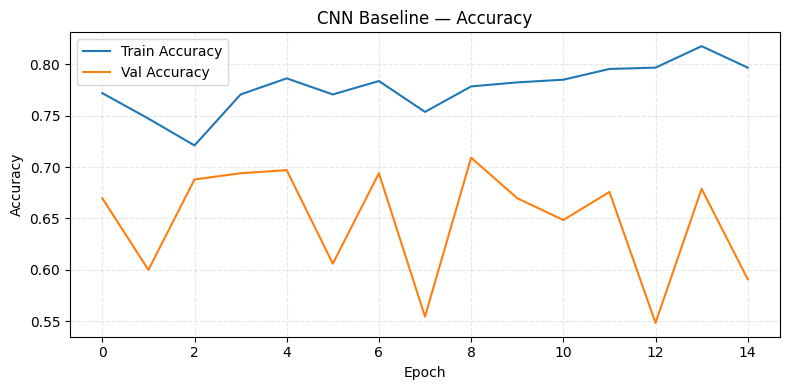

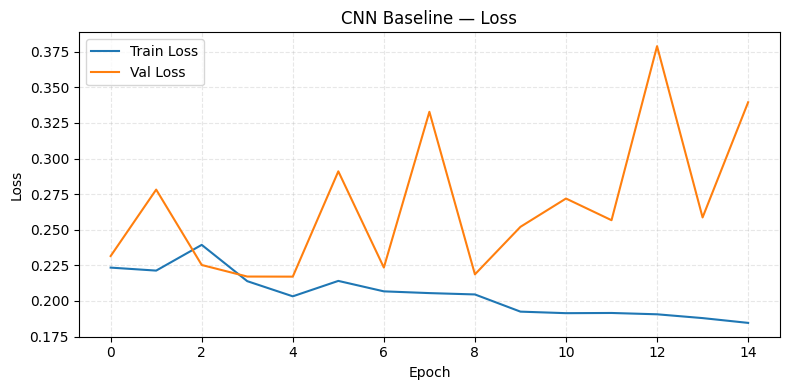

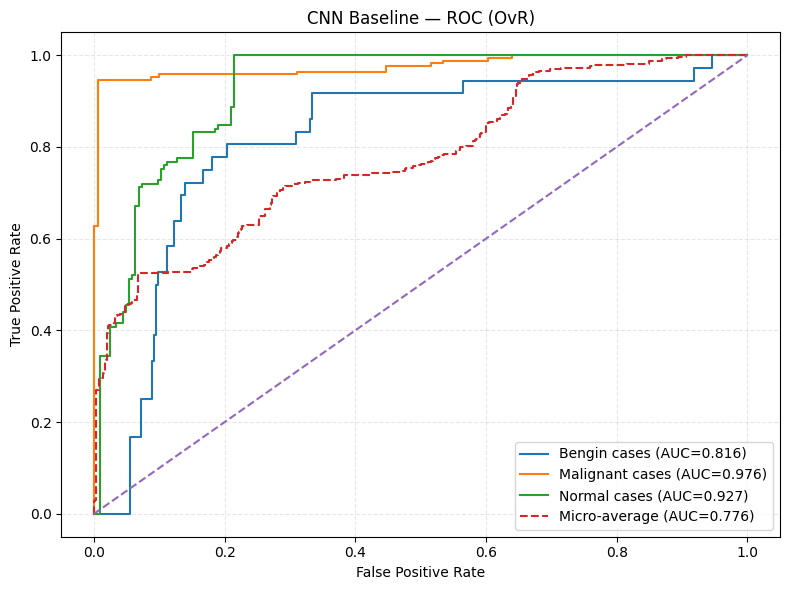

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9033 - loss: 0.0817 - val_accuracy: 0.9364 - val_loss: 0.0624
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8787 - loss: 0.0963 - val_accuracy: 0.9242 - val_loss: 0.0580
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9247 - loss: 0.0720 - val_accuracy: 0.9000 - val_loss: 0.0574
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9155 - loss: 0.0717 - val_accuracy: 0.9485 - val_loss: 0.0586
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9352 - loss: 0.0607 - val_accuracy: 0.9545 - val_loss: 0.0551
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9372 - loss: 0.0597 - val_accuracy: 0.9515 - val_loss: 0.0484
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9230 - loss: 0.0713 - val_accuracy: 0.9545 - val_loss: 0.0518
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9279 - loss: 0.0659 - val_accuracy: 0.9606 - val_loss

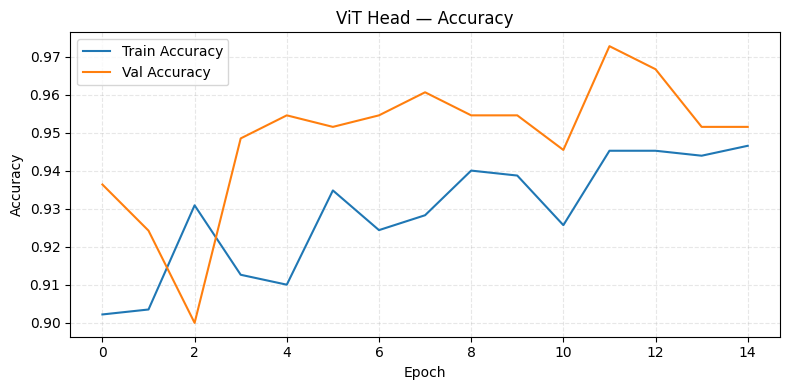

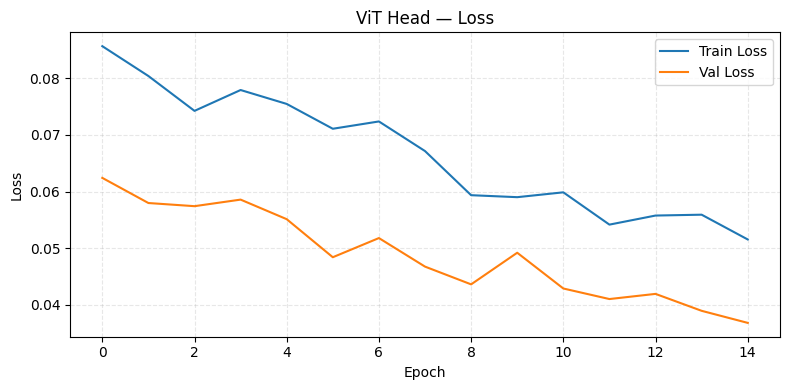

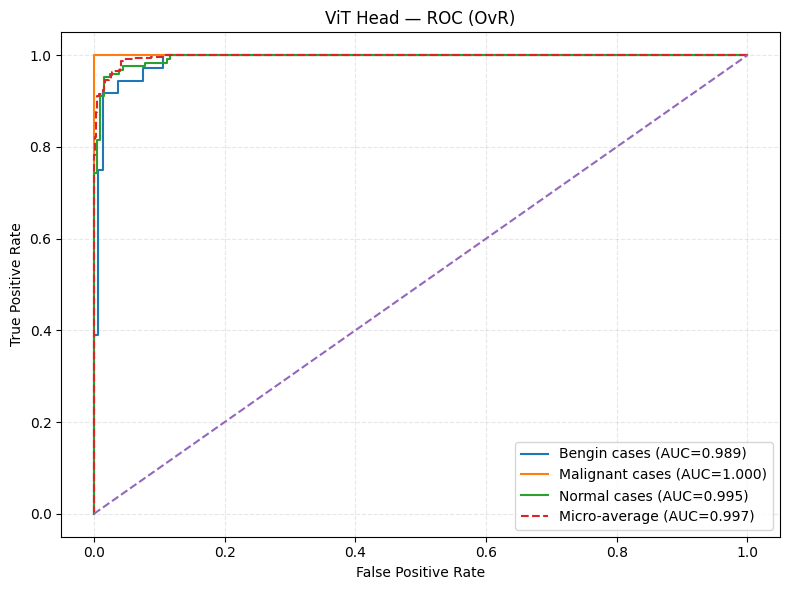

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 64s 622ms/step - accuracy: 0.9027 - loss: 0.0917 - val_accuracy: 0.9030 - val_loss: 0.0737
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 581ms/step - accuracy: 0.9094 - loss: 0.0841 - val_accuracy: 0.9091 - val_loss: 0.0704
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 582ms/step - accuracy: 0.9166 - loss: 0.0802 - val_accuracy: 0.9333 - val_loss: 0.0717
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 590ms/step - accuracy: 0.9143 - loss: 0.0828 - val_accuracy: 0.9091 - val_loss: 0.0666
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 599ms/step - accuracy: 0.9072 - loss: 0.0795 - val_accuracy: 0.9212 - val_loss: 0.0646
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 584ms/step - accuracy: 0.9151 - loss: 0.0853 - val_accuracy: 0.9152 - val_loss: 0.0638
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 593ms/step - accuracy: 0.9190 - loss: 0.0706 - val_accuracy: 0.9364 - val_loss: 0.0631
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 591ms/step - accuracy: 0.9287 - loss: 0.0768 - val_accu

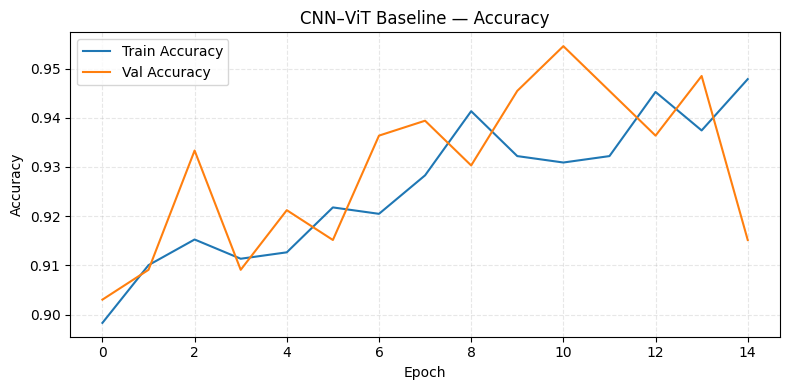

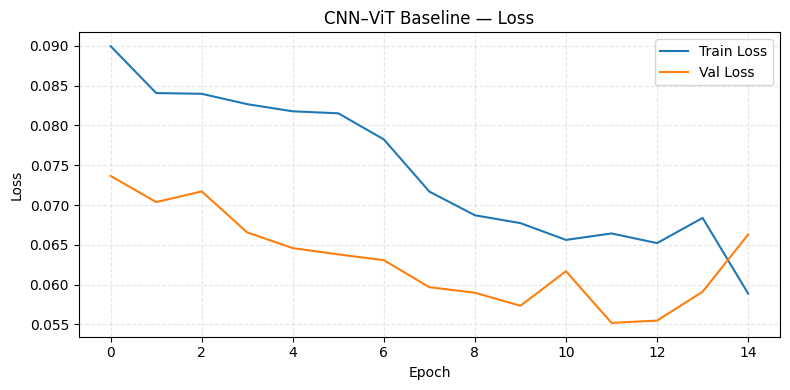

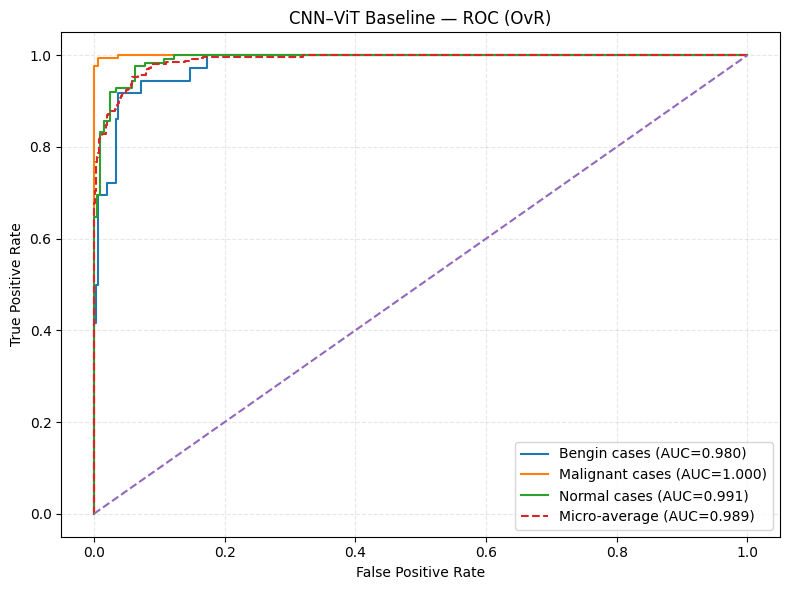

In [24]:
# 1) CNN
hist_cnn = train_and_plot_cnn(
    cnn_model, cnn_train, cnn_val,
    epochs=EPOCHS_CNN,
    class_weights=class_weights,
    title="CNN Baseline",
    lr=1e-4
)

# 2) ViT head (feature-only)
hist_vit = train_and_plot_vit(
    vit_model, vit_train, vit_val,
    epochs=EPOCHS_VIT,
    class_weights=class_weights,
    title="ViT Head",
    lr=1e-4
)

# 3) CNN–ViT baseline (fusion)
hist_cnnvit = train_and_plot_fusion(
    cnnvit_model, fusion_train, fusion_val,
    epochs=EPOCHS_CNNVIT,
    class_weights=class_weights,
    title="CNN–ViT Baseline",
    lr=1e-4
)